### Import libraries

In [1]:
import numpy as np
from random import randrange
import operator
import pandas as pd
import matplotlib.pyplot as plt

### Create support functions

In [2]:
# function that calculate mean squared error
def mean_squared_error(y):
    """It takes label dataset as input and returns value for mean squared error"""
    mse=0
    pred=np.mean(y)  # find mean value in label dataset
    for i in range(len(y)):
        error=y[i]-pred  # find error for each instance
        mse+=error*error # total squared error
    return mse/len(y)  # return mean square error

In [3]:
# function that calculates loss function for Decision Tree regressor
def loss_function_dt(left_labels, right_labels):
    """It takes two datasets as input and calculate cost function based on mean squared error"""
    n_labels=len(left_labels)+len(right_labels) # total number of samples from both datasets
    prob_left=len(left_labels)/n_labels  # probability (weighted by test size) for first dataset
    prob_right=len(right_labels)/n_labels   # probability (weighted by test size) for second dataset
    loss=(prob_left*mean_squared_error(left_labels)+prob_right*mean_squared_error(right_labels)) # calculate cost function
    return loss

In [4]:
# function that calculates mean value
def find_mean(y):
	return np.mean(y)

In [5]:
# function that find all potential splits of feature dataset
def splits(X):
	splits={}
	n_columns=X.shape[1]
	for column in range(n_columns):
		splits[column] = []
		values=X[:,column]
		unique_values=np.unique(values)

		for index in range (1,len(unique_values)):
			current_value = unique_values[index]
			previous_value = unique_values[index-1]
			split=(current_value+previous_value)/2
			splits[column].append(split)

	return splits

In [6]:
def data_split(X,y, column, value):
	data=np.column_stack((X,y))
	split_column=X[:,column]
	left_split_y=data[np.where([split_column<=value]),-1:]
	right_split_y=data[np.where([split_column>value]),-1:]
	left_split_x=data[np.where([split_column<=value]),:-1]
	right_split_x=data[np.where([split_column>value]),:-1]

	return left_split_x[1], right_split_x[1],left_split_y[1], right_split_y[1]

In [7]:
# function that find the best split of dataset based on minimal loss
def best_split(X,y):
    potential_splits=splits(X)
    loss=9999999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            _,_,left_data, right_data = data_split(X,y,column_index,value)
            current_loss=loss_function_dt(left_data,right_data)
            if current_loss<loss:
                loss=current_loss
                best_split_column=column_index
                best_split_value=value

    return best_split_column, best_split_value

In [8]:
#Function that splits test and training dataset
def train_test_split(X,y,ratio):
	random_order = np.random.permutation(len(X))
	X,y = X[random_order], y[random_order]
	test_size=int(ratio*len(X))
	train_size=int(len(X)-test_size)
	X_train=X[:train_size,:]
	y_train=y[:train_size]
	X_test=X[-test_size:,:]
	y_test=y[-test_size:]

	return X_train, y_train, X_test, y_test

In [9]:
# function that perform bootstraping
def sub_sampling(X,y,sample_size):
	dataset=np.column_stack((X,y))
	empty_array = np.array([], dtype=np.int64).reshape(0,X.shape[1]+1)
	n_samples=int(len(dataset)*sample_size)
	for i in range(n_samples):
		index=randrange(len(dataset))
		if i==0:
			sample_array=np.vstack([empty_array, dataset[index].reshape(1,X.shape[1]+1)])
		else:
			sample_array=np.concatenate((sample_array, dataset[index].reshape(1,X.shape[1]+1)), axis=0)

	return sample_array[:,:-1], sample_array[:,-1:]

In [10]:
# function that find categorical features and convert them to numerical

def cat_to_num(data):
	for i in range(data.shape[1]):
		unique_values=np.unique(data[:,i])
		if len(unique_values)<10:
			for j in range(data.shape[0]):
				data[j,i]=unique_values.tolist().index(data[j,i])
	return data

In [11]:
# function that create out of bag dataset

def find_oob(all_data, sampled_data):
    all_data_view = all_data.view([('',all_data.dtype)]*all_data.shape[1])
    sampled_data_view = sampled_data.view([('',sampled_data.dtype)]*sampled_data.shape[1])
    intersected = np.isin(all_data_view, sampled_data_view,invert=False)
    lista=[]
    for i in range(len(all_data)):
        if intersected[i]:
            lista.append(i)
    oob_data=np.delete(all_data,lista,0)
    return oob_data

### Classification algorithms

#### Decision Tree

In [12]:
#Decision Tree Regressor training function
def decision_tree_regression(X,y,depth=0, max_depth=3,min_samples=3):
	X=cat_to_num(X)
	if (len(X)<min_samples) or (depth==max_depth):
		result=find_mean(y)
		return result		
	else:
		depth+=1
		possible_splits=splits(X)
		split_column,split_value=best_split(X,y)
		left_split_x, right_split_x,left_split_y, right_split_y= data_split(X,y, split_column, split_value)

		condition="{} <= {}".format(split_column, split_value)
		sub_tree={condition: []}

		true_node=decision_tree_regression(left_split_x,left_split_y, depth,max_depth, min_samples)
		false_node=decision_tree_regression(right_split_x,right_split_y, depth,max_depth, min_samples)

		if true_node==false_node:
			sub_tree=true_node
		else:
			sub_tree[condition].append(true_node)
			sub_tree[condition].append(false_node)

		return sub_tree


In [13]:
# Decision Tree Regressor predict function
def predict_result(input_data,model):
	condition=list(model.keys())[0]
	feature,_,value=condition.split()

	if input_data[int(feature)] <= float(value):
		result=model[condition][0]
	else:
		result=model[condition][1]

	if not isinstance(result,dict):
		return result
	else:
		residual_tree=result
		return predict_result(input_data,residual_tree)

#### Random Forest

In [14]:
# Random Forest Regressor training function
def random_forest_regression(X,y,n_trees=20, sample_size=0.9, max_depth=3, min_samples=3):
    dataset=np.column_stack((X,y))
    trees=[]
    X_oob_list=[]
    y_oob_list=[]
    for i in range(n_trees):
        X_sample, y_sample=sub_sampling(X,y,sample_size)
        tree=decision_tree_regression(X_sample,y_sample,max_depth=max_depth,min_samples=min_samples)
        current_data=np.column_stack((X_sample,y_sample))
        oob_data=find_oob(dataset,current_data)
        X_oob=oob_data[:,:-1]
        y_oob=oob_data[:,-1:]
        trees.append(tree)
        X_oob_list.append(X_oob)
        y_oob_list.append(y_oob)
    return trees,X_oob_list,y_oob_list

In [15]:
# Random Forest Regressor predict function
def predict_result_random_forest(input_data,trees):
	results=[]
	for tree in trees:
		result=predict_result(input_data,tree)
		results.append(result)

	final_result=find_mean(results)

	return final_result

#### Gradient Boosting

In [16]:
# Gradient Boosting training function
def gradient_boosting(X,y, max_depth=3, min_samples=3,n_steps=5):
    """ It takes Decision Tree parameters and number of predictors as input, and returns list of trees"""
    trees=[]  # assign empty list
    new_y=y  # assign new variable for labels
    for i in range(n_steps): # iterate through all predictors
        if np.mean(new_y)!=0:  # continoue if residual error is not 0
            tree=decision_tree_regression(X,new_y,max_depth=max_depth,min_samples=min_samples)  # train DT
            for row in range(len(X)):  # iterate through all samples
                prediction=predict_result(X[row],tree)  # make prediction
                residual=new_y[row]-prediction  # find residual error
                new_y[row]=residual  # assign error as new label
            trees.append(tree)
    return trees

In [17]:
# Gradient Boosting predict function
def grad_boost_predict(input_data,trees):
    """It takes data for prediction and trees from Gradient Boosting as input, and returns result of prediction"""
    predictions=[]  # assign empty list for predictions
    for tree in trees:  # iterate through trees
        prediction=predict_result(input_data,tree)  # make predictions
        predictions.append(prediction)
    result=sum(predictions)  # sum all predictions
    return result

### Model's evaluation functions

In [18]:
# function that calculates mean squared error of test set for Decision Tree Regressor
def DT_MSE(X_test,y_test,tree):
	total_error=0
	for i in range(len(X_test)):
		prediction=predict_result(X_test[i],tree)
		error=prediction-y_test[i]
		total_error+=error*error
	mse=total_error/len(y_test)
	return mse

In [19]:
# function that calculates mean squared error of test set for Random Forest Regressor
def RF_MSE(X_test,y_test,trees):
	total_error=0
	for i in range(len(X_test)):
		prediction=predict_result_random_forest(X_test[i],trees)
		error=prediction-y_test[i]
		total_error+=error*error
	mse=total_error/len(y_test)
	return mse

In [20]:
# function that calculates mean squared error of test set for Gradient Boosting
def GB_MSE(X_test,y_test,models):
	total_error=0
	for i in range(len(X_test)):
		prediction=grad_boost_predict(X_test[i],models)
		error=prediction-y_test[i]
		total_error+=error*error
	mse=total_error/len(y_test)
	return mse

In [21]:
# function that calculate out-of-bag evaluation
def oob_mse(trees,X_oob_list,y_oob_list):
    scores=[]
    for i in range(len(trees)):
        pred=DT_MSE(X_oob_list[i],y_oob_list[i],trees[i])
        scores.append(pred)    
    return np.mean(scores)

### Testing on AIRFOILSELFNOISE dataset

In [22]:
# Load AirfoilSelfNoise dataset
df=pd.read_csv('AirfoilSelfNoise.csv')
X = df[['f', 'alpha', 'c', 'U_infinity', 'delta']].values
y = df[['SSPL']].values

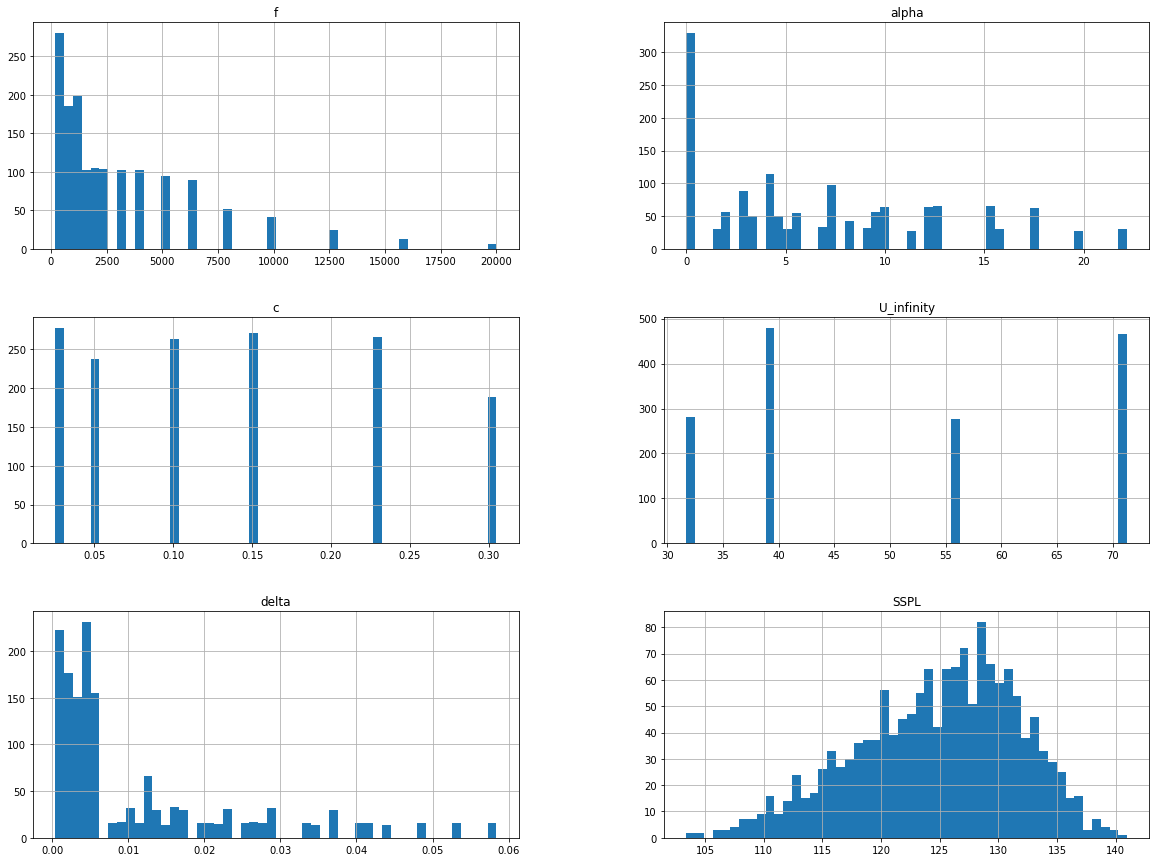

In [23]:
# Dataset visualisation
df.hist(bins=50, figsize=(20,15))
plt.show()

In [24]:
# Split data on training and test dataset
X_train, y_train, X_test, y_test = train_test_split(X,y,0.3)

In [25]:
# Decision Tree Regressor
decision_tree=decision_tree_regression(X_train,y_train)

# Decision Tree MSE
dt_mse = DT_MSE(X_test, y_test,decision_tree)
print ("MSE for Decision Tree Algorithm is ", dt_mse)

MSE for Decision Tree Algorithm is  [28.58112615]


In [26]:
# Random Forest Regressor
random_trees,X_oob,y_oob=random_forest_regression(X_train,y_train)

# Random Forest MSE
rf_mse = RF_MSE(X_test, y_test,random_trees)
print ("MSE for Random Forest Algorithm is ", rf_mse)

# out-of-bag MSE
oob=oob_mse(random_trees,X_oob,y_oob)
print ("Out-of-bag MSE for Random Forest Algorithm is ", oob)

MSE for Random Forest Algorithm is  [23.3289445]
Out-of-bag MSE for Random Forest Algorithm is  29.41263009548431


In [27]:
# Gradient Boosting
gb_trees=gradient_boosting(X_train,y_train)

# Gradient Boosting MSE
gb_mse = GB_MSE(X_test,y_test,gb_trees)
print ("MSE for Gradient Boosting Algorithm is ", gb_mse)

MSE for Gradient Boosting Algorithm is  [37.11274081]


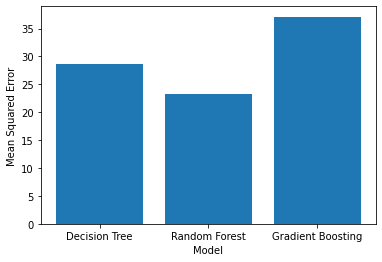

In [28]:
# Models evaluation visualisation
models_list=['Decision Tree','Random Forest','Gradient Boosting']
mse_list=[dt_mse[0],rf_mse[0],gb_mse[0]]
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.bar(models_list, mse_list)
plt.show()

### Testing on WINE QUALITY dataset

In [33]:
# Load Wine quality dataset
df_w=pd.read_csv('winequality-red.csv')
X_w = df_w[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']].values
y_w = df_w[['quality']].values

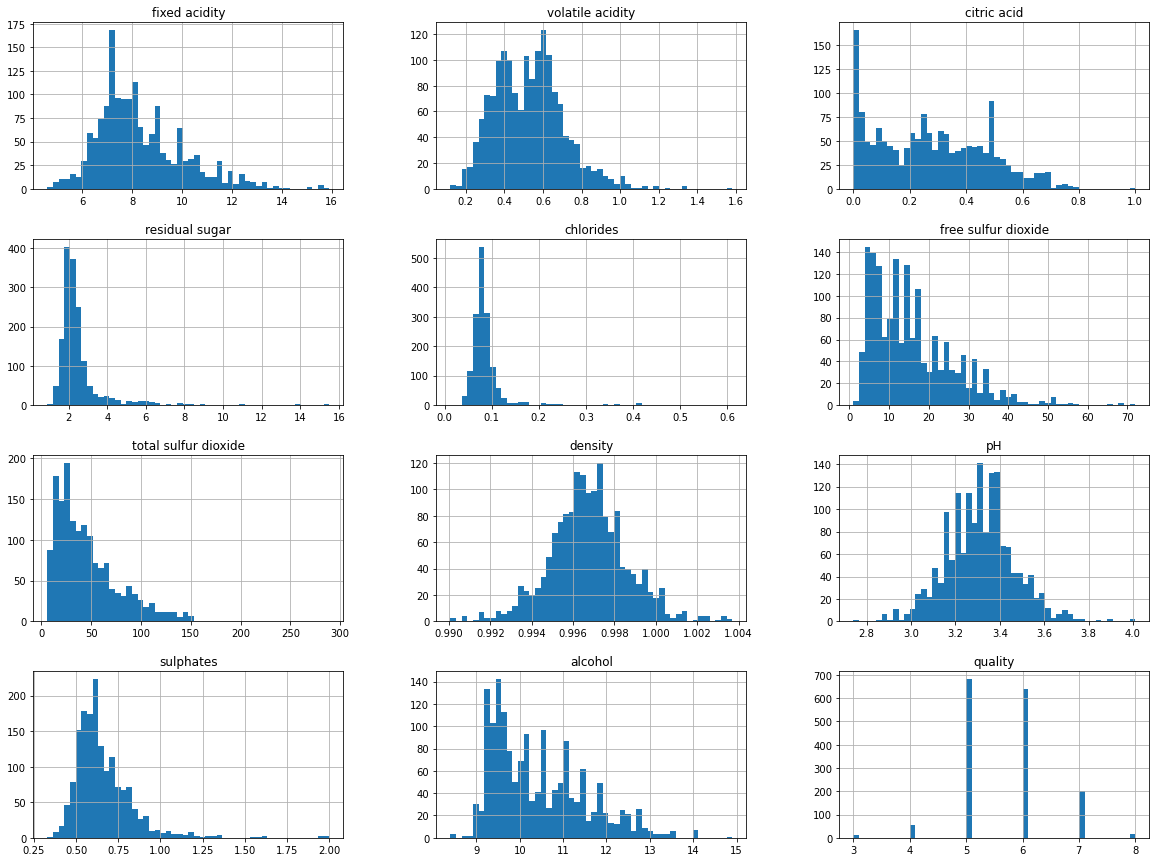

In [34]:
# Dataset visualisation
df_w.hist(bins=50, figsize=(20,15))
plt.show()

In [35]:
# Split data on training and test dataset
X_train_w, y_train_w, X_test_w, y_test_w = train_test_split(X_w,y_w,0.2)


In [36]:
# Decision Tree Regressor
decision_tree_w=decision_tree_regression(X_train_w,y_train_w)

# Decision Tree MSE
dt_mse_w = DT_MSE(X_test_w, y_test_w,decision_tree_w)
print ("MSE for Decision Tree Algorithm is ", dt_mse_w)

MSE for Decision Tree Algorithm is  [0.43657933]


In [37]:
# Random Forest Regressor
random_trees_w,X_oob_w,y_oob_w=random_forest_regression(X_train_w,y_train_w)

# Random Forest MSE
rf_mse_w = RF_MSE(X_test_w, y_test_w,random_trees_w)
print ("MSE for Random Forest Algorithm is ", rf_mse_w)

# out-of-bag MSE
oob_w=oob_mse(random_trees_w,X_oob_w,y_oob_w)
print ("Out-of-bag MSE for Random Forest Algorithm is ", oob_w)

MSE for Random Forest Algorithm is  [0.39722779]
Out-of-bag MSE for Random Forest Algorithm is  0.526394507646059


In [38]:
# Gradient Boosting
gb_trees_w=gradient_boosting(X_train_w,y_train_w,n_steps=2)

# Gradient Boosting MSE
gb_mse_w = GB_MSE(X_test_w,y_test_w,gb_trees_w)
print ("MSE for Gradient Boosting Algorithm is ", gb_mse_w)

MSE for Gradient Boosting Algorithm is  [0.45148222]


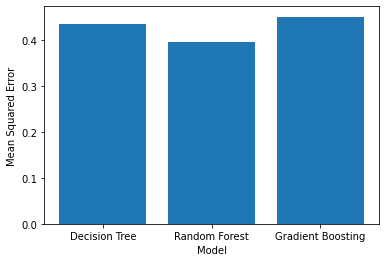

In [39]:
# Models evaluation visualisation
models_list_w=['Decision Tree','Random Forest','Gradient Boosting']
mse_list_w=[dt_mse_w[0],rf_mse_w[0],gb_mse_w[0]]
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.bar(models_list_w, mse_list_w)
plt.show()